In [3]:
## Packages
'''Import all the necessary packages and modules'''
import pandas as pd
from pycroscopy.io.translators.df_utils.dm_utils import read_dm3
import numpy as np # package for playing with matrices
import matplotlib.pyplot as plt
import sys, os # python modules for interacting with computer
# from sklearn.decomposition import PCA
from tkinter import filedialog # interface for opening a file explorer
from tkinter import * # * imports all files in tkinter
import glob
# from sklearn import preprocessing
import cv2


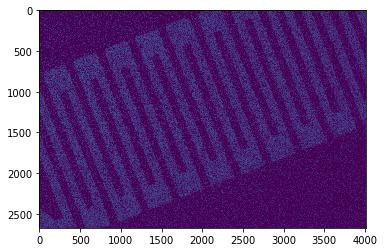

In [24]:
plt.imshow(thresh(denoise.remove_outliers(im1),simple=True))

In [2]:
## Data Directory GUI
'''Getting data directory so data can easily be imported '''
def get_dir(new=True):
    '''Opens a window to select directory if new==False gets current directory
    Returns the directory as a string
    '''
    if new==True:
        root = Tk() # Tk() is a function in tkinter that opens a window
        root.directory = filedialog.askdirectory() # opens explorer window so you can find the folder of choice
        root.withdraw() # closes the tkinter window since it's unnecessary
        oldcwd = os.getcwd() # saves old called working directory (place where data is drawn from) as oldcwd use os.chdir(oldcwd) to go back
        os.chdir(root.directory) # sets new directory
        newcwd = os.getcwd() # saves new directory name as newcwd
        return root.directory
    if new==False:
        cd=os.getcwd()
        return cd
folder=get_dir()

In [4]:
import denoise

In [5]:
## Load Data use for .csv data
''' Makes a list of all the files with the extension use * to use for importing'''

path = folder + '/'+'*.dm3' # Change '' as needed
file_list=sorted(glob.glob(path))
list(enumerate(file_list)) # list all files and their corresponding index in the list file_list

[(0,
  'Z:/JEOL 3010/Comb Sample PP test/OnOffPump\\ContBeam_.5s_leftside_1.dm3'),
 (1,
  'Z:/JEOL 3010/Comb Sample PP test/OnOffPump\\PulseBeam_2.6_.5s_leftside.dm3'),
 (2,
  'Z:/JEOL 3010/Comb Sample PP test/OnOffPump\\PulseBeam_2.6_.5s_leftside_pumped_no_-dB_1.dm3')]

In [6]:
def load_dm3(filename,get_meta=False, stack=False):
    '''Loads a single dm3 into a numpy array. If get_meta=True gets all corresponding metadata aswell
    Returns an numpy array of the dm3
    '''
    if (stack==True) | (np.array(filename).size!=1):
        
        image_size= read_dm3(filename[0])[0].shape
        num_images=len(filename)
        stack_size=(image_size[0],image_size[1], len(filename)) # set size of data_stack 
        data_stack=np.zeros(stack_size) # Preallocate the data_stack
        meta_size=[]
        '''Determine the size of the meta data'''
        for n in range(len(filename)): 
            meta_size.append(len(list(read_dm3(filename[n])[1].items())))
        meta_dim1=np.max(meta_size)
        meta_stack=np.zeros((meta_dim1,2,len(filename)),dtype=np.object_)
        '''Parse the image intensities from the meta data and load into data_stack and meta_stack'''
        for n in range(len(filename)):
            data_stack[:,:,n]=read_dm3(filename[n])[0]
        if get_meta==True:
            for n in range(len(filename)):
                string_stack=list(read_dm3(filename[n])[1].items())
                if len(string_stack)<meta_dim1:
                    diff=meta_dim1-len(string_stack)
                    for x in range(diff):
                        string_stack.append(([],[]))
                meta_stack[:,:,n]=string_stack # Use meta_stack[:,:,#] to look at the meta_data for file #
            return data_stack, meta_stack
            
        return data_stack
        
    image_size= read_dm3(filename)[0].shape
    image=np.zeros(image_size)
    meta=np.zeros((len(list(read_dm3(filename)[1].items())),2),dtype=np.object_)
    image[:,:]=read_dm3(filename)[0]
    meta[:,:]=list(read_dm3(filename)[1].items())
    if get_meta==True:
        return image, meta
    return image

In [190]:
def shift_image(im,shift,delete=True,fill=0):
    from scipy.ndimage import fourier_shift
    """Shifts image based on scipy.ndimage shift vector.

    Parameters
    ----------
    x : np.array
      Shape N X T.

    shift : sequence
        The size of the box used for filtering.
        If a float, `shift` is the same for all axes. If a sequence, `shift`
        has to contain one value for each axis.

    Returns
    -------
    fourier_shift : ndarray
        The shifted input.

    """
    
    rank=im.ndim
    if hasattr(shift, '__iter__'):
        n_shift = list(shift)
    else:
        n_shift = [shift] * rank  
    fft_im=fourier_shift(np.fft.fftn(im),n_shift)
    shifted_im=np.fft.ifftn(fft_im)
#     return shifted_im,n_shift
    if delete ==True:
        ylim=int(n_shift[0])
        xlim=int(n_shift[1])
        if ylim>=0:
            shifted_im[0:ylim,:]=fill
        if ylim<0:
            shifted_im[ylim:,:]=fill
        if xlim>=0:
            shifted_im[:,0:xlim]=fill
        if xlim<0:
            shifted_im[:,xlim:]=fill
        
    return np.array(shifted_im)

def to_8bit(image):
    im=image.copy()
    im=(im-np.min(im)).real
    im=(im/np.max(im))*255

    return im.astype(int)
def to_binary(image):
    im=image.copy()
    mean=np.mean(im)
    im[im<=mean]=0
    im[im>mean]=1
    return im.astype(int)
def thresh(image,threshtype='local', binary=True, simple=False):
    im=image.copy()
    if simple==True:
        im[im<0]=0
        return im

    if threshtype=='global':
        from skimage.filters import threshold_otsu
        thresh = threshold_otsu(im)
    if threshtype=='local':
        from skimage.filters import threshold_sauvola
        thresh = threshold_sauvola(im)
        if binary==False:
            return thresh
    binary = im> thresh
    return binary.astype(int)
def gaussian_filter(image,sig=3):
    from skimage.filters import gaussian
    im=image.copy()
    g = gaussian(im, sigma=sig)
    return g
def binarize(image,sig=3,threshtype='local'):
    im=image.copy()
    t=thresh(im,threshtype=threshtype)
    filt=gaussian_filter(t,sig)
    binary=thresh(filt,threshtype='global')
    return binary.astype(int)

def rigid_registration(to_be_registered,reference,pixel_resolution,get_shift=False):
    from skimage.feature import register_translation
#     to_be_registered_bin=to_binary(to_be_registered)
#     reference_bin=to_binary(reference)
#     to_be_registered_8=to_8bit(to_be_registered_bin)
#     reference_8=to_8bit(reference_bin)
#     return to_binary(to_be_registered_bin-reference_bin)
    to_be_registered_bin=binarize(to_be_registered)
    reference_bin=binarize(reference)
    upsample_factor=1/pixel_resolution
    shift, error, diffphase = register_translation(reference_bin,to_be_registered_bin, upsample_factor)
    shifted_image=shift_image(to_be_registered,shift)
    if get_shift==True:
        return shifted_image.real, shift
    return shifted_image.real



In [8]:
def coord_to_im(xyz,shape='square'):
    '''Return image from xyz coordinates as an nxm matrix'''
    z=xyz[:,2]
    if shape=='square':
        l=int(xyz.shape[0]**.5)
        image=z.reshape(l,l).T
        return image

    y,x=shape
    image=z.reshape(y,x)
        
    return image

def im_to_coord(image):
    '''Return image xyz coordinates as an X*Yx3 matrix'''
    n,m=image.shape
    yy,xx=np.meshgrid(np.arange(n),np.arange(m))
    x=xx.flatten()
    y=yy.flatten()
    z=image[y.astype(np.int),x.astype(np.int)]
    im_coordinates=np.concatenate((x[:,np.newaxis],y[:,np.newaxis],z[:,np.newaxis]),axis=1)
    return im_coordinates
def make_odd(N):
    X=int(N)
    if X%2:
        return N
    Y=X+1
    return Y
def make_even(N):
    X=int(N)
    if X%2:
        Y=X+1
        return Y
    return N

In [191]:
im1=load_dm3(file_list[1])
im2=load_dm3(file_list[2])

In [192]:
im2_shifted=rigid_registration(im2,im1,.5)

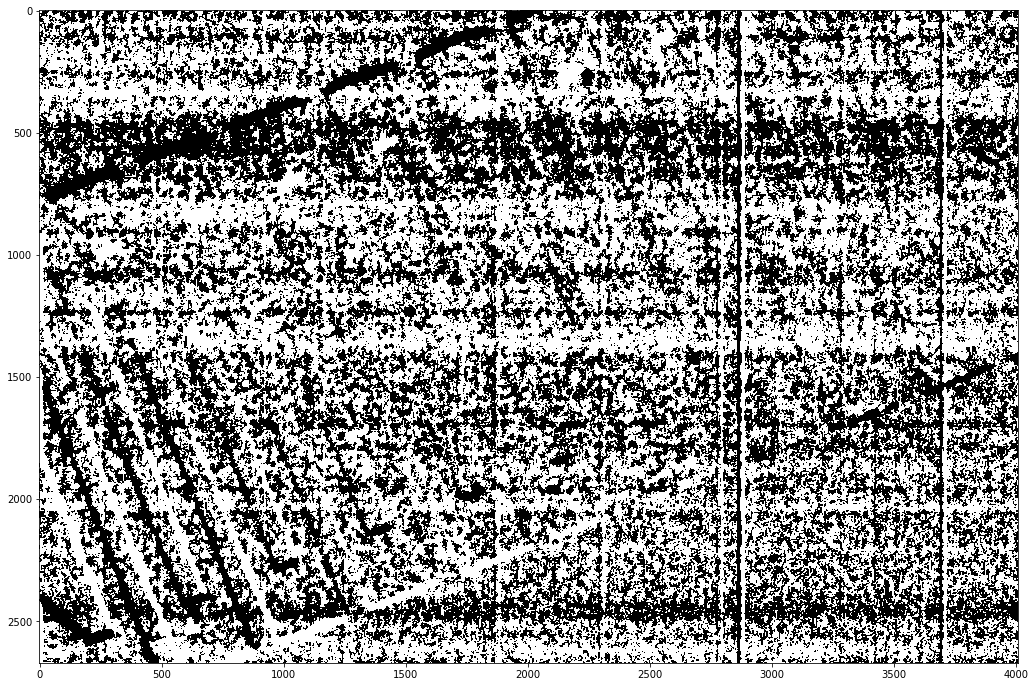

In [194]:
plt.figure(figsize=(18,12))
plt.imshow(binarize(im2_shifted-im1))

In [195]:
def image_correlation(image1, image2):
    """Correlate each n with each m.

    Parameters
    ----------
    x : np.array
      Shape N X T.

    y : np.array
      Shape M X T.

    Returns
    -------
    np.array
      N X M array in which each element is a correlation coefficient.

    """
    im1=im_to_coord(image1)
    im2=im_to_coord(image2)
    z1=im1[:,2]
    z2=im2[:,2]
    mu_z1 = z1.mean()
    mu_z2 = z2.mean()
    n = z1.shape[0]
    s_z1 = z1.std(0, ddof=n - 1)
    s_z2 = z2.std(0, ddof=n - 1)
    cov = np.dot(z1,
                 z2.T) - n * np.dot(mu_z1,
                                  mu_z2)
    return cov / np.dot(s_z1, s_z2)

## Did we do better?

In [200]:
print('Correlation before shift =',round(image_correlation(binarize(im1),binarize(im2)),2))
print('Correlation after shift =',round(image_correlation(binarize(im1),binarize(im2_shifted)),2))

Correlation before shift = 0.88
Correlation after shift = 0.96


In [ ]:
import numpy as np

def image_correlation(image1, image2):
    """Correlate each n with each m.

    Parameters
    ----------
    x : np.array
      Shape N X T.

    y : np.array
      Shape M X T.

    Returns
    -------
    np.array
      N X M array in which each element is a correlation coefficient.

    """
    im1=im_to_coord(image1)
    im2=im_to_coord(image2)
    z1=im1[:,2]
    z2=im2[:,2]
    mu_z1 = z1.mean()
    mu_z2 = z2.mean()
    n = z1.shape[0]
    s_z1 = z1.std(0, ddof=n - 1)
    s_z2 = z2.std(0, ddof=n - 1)
    cov = np.dot(z1,
                 z2.T) - n * np.dot(mu_z1,
                                  mu_z2)
    return cov / np.dot(s_z1, s_z2)

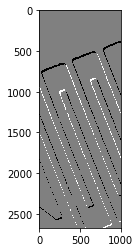

In [170]:
plt.imshow(binarize(im2t)-binarize(im1t))

In [38]:
from skimage.feature import (corner_harris, corner_peaks, BRIEF,match_descriptors)
corner_peaks(corner_harris(binarize(im1)), min_distance=1)

array([[   1,    1],
       [   1, 2021],
       [   1, 2249],
       ...,
       [2670,  799],
       [2670,  809],
       [2670, 4006]], dtype=int64)

In [138]:
(im1[:,:1000]/mim1).max()

1.0

In [129]:
im1t[:,:1000].max()

17.40839102836181

In [139]:
# mim1t=im1t[:,:1000].max()
(im1[:,:1000]/mim1).min()

-1.781081081081081

In [147]:
desc

(3307716,)

C:\Users\kbs1\AppData\Local\Continuum\anaconda3\envs\peabody\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\kbs1\AppData\Local\Continuum\anaconda3\envs\peabody\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


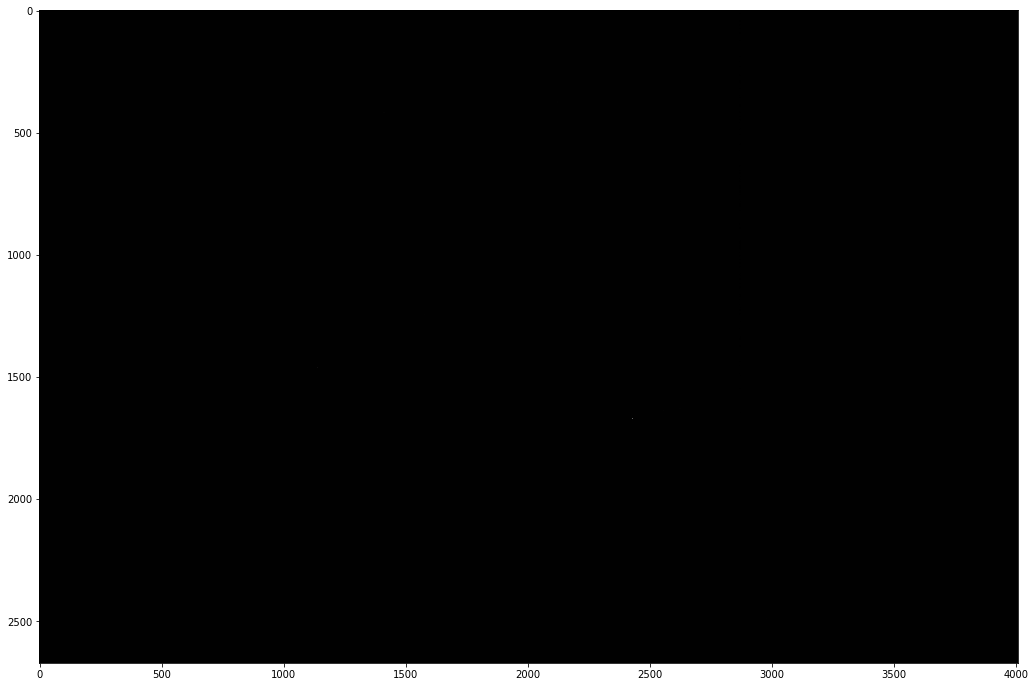

In [157]:
from skimage.filters import gaussian, median, wiener
from skimage.feature import corner_fast
mim1=np.abs(im1[:,:1000]).max()
im1t=median(im1[:,:1000]/mim1)
desc=hog(im1t,)
plt.figure(figsize=(18,12))
plt.imshow(corner_harris(im1))

In [160]:
keypoints1

array([], shape=(0, 2), dtype=int64)

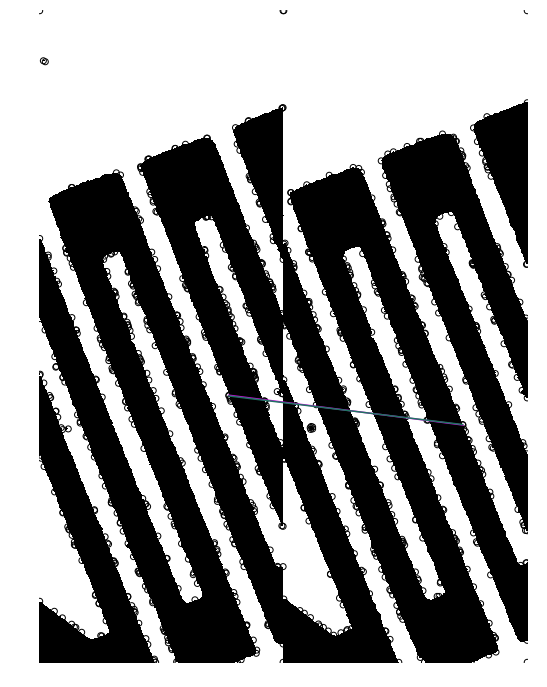

In [169]:
from skimage.feature import ORB, match_descriptors, corner_harris, plot_matches, corner_peaks, corner_fast
from skimage.measure import ransac
from skimage.transform import EuclideanTransform
descriptor_extractor = ORB(n_keypoints=500)

mim1=np.abs(im1[:,:1000]).max()
im1t=binarize(im1[:,:1000])
mim2=np.abs(im2[:,:1000]).max()
im2t=median(im2[:,:1000])

# im1t=gaussian(denoise.remove_outliers(im1)[:,:1000],sigma=3)
# im2t=gaussian(denoise.remove_outliers(im2)[:,:1000],sigma=3)
descriptor_extractor.detect_and_extract(im1t)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(im2t)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

# keypoints1 = corner_peaks(corner_harris(im1t), min_distance=1)
# keypoints2 = corner_peaks(corner_harris(im2t), min_distance=1)
# extractor = BRIEF(descriptor_size=512,patch_size=100)
# extractor.extract(im1t, keypoints1)
# descriptors1 = extractor.descriptors
# extractor.extract(im2t, keypoints2)
# descriptors2 = extractor.descriptors
matches12 = match_descriptors(descriptors1, descriptors2,max_distance=2, cross_check=True)

src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

model_robust, inliers = ransac((src, dst), EuclideanTransform,
                               min_samples=20, residual_threshold=5, max_trials=300)
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
plot_matches(ax, im1t, im2t, keypoints1, keypoints2, matches12[inliers])
ax.axis('off')
plt.show()

# fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(18,12))

# plt.gray()

# plot_matches(ax, im1t, im2t, keypoints1, keypoints2, matches12)
# ax.axis('off')
# ax.set_title("Original Image vs. Transformed Image")
# plt.show()

In [101]:
from skimage.transform import warp


image1_ = im1
output_shape = im1.shape

image2_ = warp(im2, model_robust.inverse, preserve_range=True,
               output_shape=output_shape, cval=-1)

# image2_ = np.ma.array(image2_, mask=image2_==-1)

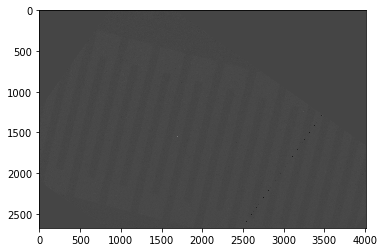

In [102]:
plt.imshow(image2_)

In [ ]:
from skimage.filters import threshold_sauvola
plt.imshow(threshold_sauvola(im1))

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches, ORB)
from skimage.transform import warp, AffineTransform
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac


# generate synthetic checkerboard image and add gradient for the later matching
checkerboard = img_as_float(data.checkerboard())
img_orig = np.zeros(list(checkerboard.shape) + [3])
img_orig[..., 0] = checkerboard
gradient_r, gradient_c = (np.mgrid[0:img_orig.shape[0],
                                   0:img_orig.shape[1]]
                          / float(img_orig.shape[0]))
img_orig[..., 1] = gradient_r
img_orig[..., 2] = gradient_c
img_orig = rescale_intensity(img_orig)
img_orig_gray = rgb2gray(img_orig)

# warp synthetic image
tform = AffineTransform(scale=(0.9, 0.9), rotation=0.2, translation=(20, -10))
img_warped = warp(img_orig, tform.inverse, output_shape=(200, 200))
img_warped_gray = rgb2gray(img_warped)

# extract corners using Harris' corner measure
detector_extractor1 = ORB(n_keypoints=5)
detector_extractor2 = ORB(n_keypoints=5)
coords_orig = detector_extractor1.detect_and_extract(corner_harris(img_orig_gray))
coords_warped = detector_extractor2.detect_and_extract(corner_harris(img_warped_gray))

# # determine sub-pixel corner position
# coords_orig_subpix = corner_subpix(img_orig_gray, coords_orig, window_size=9)
# coords_warped_subpix = corner_subpix(img_warped_gray, coords_warped,
#                                      window_size=9)


def gaussian_weights(window_ext, sigma=1):
    y, x = np.mgrid[-window_ext:window_ext+1, -window_ext:window_ext+1]
    g = np.zeros(y.shape, dtype=np.double)
    g[:] = np.exp(-0.5 * (x**2 / sigma**2 + y**2 / sigma**2))
    g /= 2 * np.pi * sigma * sigma
    return g


def match_corner(coord, window_ext=5):
    r, c = np.round(coord).astype(np.intp)
    window_orig = img_orig[r-window_ext:r+window_ext+1,
                           c-window_ext:c+window_ext+1, :]

    # weight pixels depending on distance to center pixel
    weights = gaussian_weights(window_ext, 3)
    weights = np.dstack((weights, weights, weights))

    # compute sum of squared differences to all corners in warped image
    SSDs = []
    for cr, cc in coords_warped:
        window_warped = img_warped[cr-window_ext:cr+window_ext+1,
                                   cc-window_ext:cc+window_ext+1, :]
        SSD = np.sum(weights * (window_orig - window_warped)**2)
        SSDs.append(SSD)

    # use corner with minimum SSD as correspondence
    min_idx = np.argmin(SSDs)
    return coords_warped_subpix[min_idx]


# find correspondences using simple weighted sum of squared differences
src = []
dst = []
for coord in coords_orig_subpix:
    src.append(coord)
    dst.append(match_corner(coord))
src = np.array(src)
dst = np.array(dst)


# estimate affine transform model using all coordinates
model = AffineTransform()
model.estimate(src, dst)

# robustly estimate affine transform model with RANSAC
model_robust, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=100)
outliers = inliers == False


# compare "true" and estimated transform parameters
print(tform.scale, tform.translation, tform.rotation)
print(model.scale, model.translation, model.rotation)
print(model_robust.scale, model_robust.translation, model_robust.rotation)

# visualize correspondence
fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

inlier_idxs = np.nonzero(inliers)[0]
plot_matches(ax[0], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((inlier_idxs, inlier_idxs)), matches_color='b')
ax[0].axis('off')
ax[0].set_title('Correct correspondences')

outlier_idxs = np.nonzero(outliers)[0]
plot_matches(ax[1], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
ax[1].axis('off')
ax[1].set_title('Faulty correspondences')

plt.show()

In [ ]:
plt.imshow(binarize(corner_harris(img_orig_gray)))

In [ ]:
def get_gradient(im) :
    # Calculate the x and y gradients using Sobel operator
    grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
    grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
 
    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad

# Find the width and height of the color image
sz = im.shape
height = int(sz[0] / 3);
width = sz[1]

# Extract the three channels from the gray scale image
# and merge the three channels into one color image
im_color = np.zeros((height,width,3), dtype=np.uint8 )
for i in range(0,3) :
    im_color[:,:,i] = im[ i * height:(i+1) * height,:]

# Allocate space for aligned image
im_aligned = np.zeros((height,width,3), dtype=np.uint8 )

# The blue and green channels will be aligned to the red channel.
# So copy the red channel
im_aligned[:,:,2] = im_color[:,:,2]

# Define motion model
warp_mode = cv2.MOTION_HOMOGRAPHY

# Set the warp matrix to identity.
if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)

# Set the stopping criteria for the algorithm.
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)

# Warp the blue and green channels to the red channel
for i in range(0,2) :
    (cc, warp_matrix) = cv2.findTransformECC (get_gradient(im_color[:,:,2]), get_gradient(im_color[:,:,i]),warp_matrix, warp_mode, criteria)

    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use Perspective warp when the transformation is a Homography
        im_aligned[:,:,i] = cv2.warpPerspective (im_color[:,:,i], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else :
        # Use Affine warp when the transformation is not a Homography
        im_aligned[:,:,i] = cv2.warpAffine(im_color[:,:,i], warp_matrix, (width, height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);


# Show final output
cv2.imshow("Color Image", im_color)
cv2.imshow("Aligned Image", im_aligned)
cv2.waitKey(0)